Index(['after_holiday', 'before_holiday', 'dayofweek_mean', 'dayofweek_median',
       'gate', 'holiday', 'rainfall', 'target_value', 'temperature',
       'timestamp', 'weekday'],
      dtype='object')
### merge: target TS와 related TS
# merged_df feature 개수
10


# merged_df shape
(634, 11)


# merged_df head
   after_holiday  before_holiday  dayofweek_mean  dayofweek_median  gate  \
0              0               0             276               297    14   
1              1               0             246               278   532   
2              0               0             212               267   535   
3              0               0             218               250   526   
4              0               0               0                 0    48   

   holiday  rainfall  temperature  timestamp  weekday  target_value  
0        1       0.0         -0.6 2019-01-01        1             0  
1        0       0.0          0.2 2019-01-02        2           393  
2        0       0.0  

ValueError: Length of values (5) does not match length of index (1)

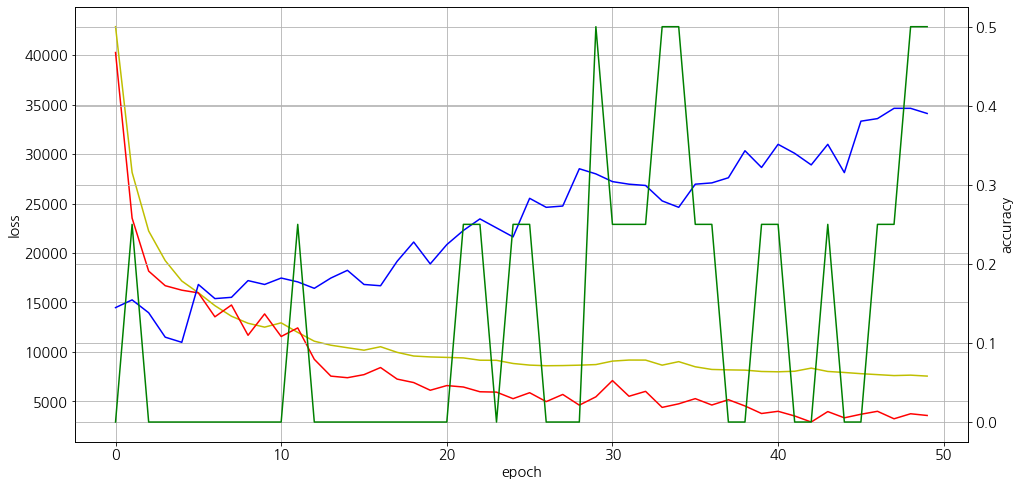

In [3]:
import os
import sys
import yaml
import datetime

import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

from sklearn.metrics import mean_squared_error

plt.rc('font', family='NanumGothic')
params = {'legend.fontsize': 'x-large',
                  'figure.figsize': (16, 8),
                 'axes.labelsize': 'x-large',
                 'axes.titlesize':'x-large',
                 'xtick.labelsize':'x-large',
                 'ytick.labelsize':'x-large',
                 'axes.grid' : True}

plt.rcParams.update(params)
   



class ldccLstm():
    
    ### 초기 설정
    def __init__(self, **kwargs):
        
        ### warning 메시지 무시
        import warnings
        warnings.filterwarnings(action='ignore')
        
        
#         ### aws python SDK 객체 생성 및 Amazon Forecast, Forecastquery, S3 에 연동, IAM 설정
#         self.fcst = ldcc_forecast_01_3.ldccForecast()
#         # region_name = ['서울': 'ap-northeast-2', '싱가포르': 'ap-southeast-1']
#         self.fcst.region_name = 'ap-northeast-2'
#         self.fcst.connect_aws()
#         self.fcst.iam_config()

        
        ### 인자 임포트 및 선언
        with open('bilstm_main_v1.yaml') as f:
            self.argData = yaml.load(f, Loader=yaml.FullLoader)

            # common
            self.train_start_date = self.argData['common']['train_start_date']
            self.train_end_date = self.argData['common']['train_end_date']
            self.test_start_date = self.argData['common']['test_start_date']
            self.test_end_date = self.argData['common']['test_end_date']
            self.modelName = self.argData['common']['modelName']
            
#             # data_import
#             self.train_readS3BucketName = self.argData['data_import']['train_readS3BucketName']
#             self.train_readS3Key = self.argData['data_import']['train_readS3Key']  
#             self.rel_readS3BucketName = self.argData['data_import']['rel_readS3BucketName']
#             self.rel_readS3Key = self.argData['data_import']['rel_readS3Key']
            
            # data_prep
            self.n_steps_in = self.argData['data_prep']['n_steps_in']
            self.n_steps_out = self.argData['data_prep']['n_steps_out']
#            self.features = self.argData['data_prep']['features']

            # train_model
            self.cell = self.argData['train_model']['cell']
            self.epochs = self.argData['train_model']['epochs']
            self.batch_size = self.argData['train_model']['batch_size']
            self.verbose = self.argData['train_model']['verbose']
            
            # save_res
            self.upload_to_s3_bool = self.argData['save_res']['upload_to_s3_bool']
            self.save_dir = self.argData['save_res']['save_dir']
        
    
    ### local에서 데이터 가져오기    
    def data_import(self, data_location, columns_list):
        
        self.merged_df = pd.read_csv('푸드본사input.csv')
        self.merged_df = pd.read_csv(data_location)
        self.merged_df = self.merged_df.astype({'timestamp':'datetime64[ns]'})
        #self.merged_df = self.merged_df[['timestamp', 'rainfall', 'temperature', 'abnormal', 'weekday', 'dayofweek_median', 'holiday', 'before_holiday', 'target_value']]
        self.merged_df = self.merged_df[columns_list]
        
        ## local에서 train 데이터 만들기
        
        self.target_df = self.merged_df[
            (self.merged_df['timestamp'] >= self.test_start_date)
            &
            (self.merged_df['timestamp'] <= self.test_end_date)
        ]
    
 
        
        
        
#         ## target TS 임포트
#         self.fcst.readS3BucketName = self.train_readS3BucketName 
#         self.fcst.readS3Key = self.train_readS3Key
#         self.target_df = self.fcst.read_s3data()   
#         self.target_df = self.target_df[['timestamp', 'target_value', 'item_id']]
#         print('### target_df 생성')
#         print('# target_df columnlist')
#         print(self.target_df.columns)
#         print('\n')
#         print('# target_df head')
#         print(self.target_df.head())
#         print('\n')
#         print('# target_df tail')
#         print(self.target_df.tail())
#         print('\n\n\n')
        
        
#         ## related TS 임포트
#         self.fcst.readS3BucketName = self.rel_readS3BucketName 
#         self.fcst.readS3Key = self.rel_readS3Key
#         self.rel_df = self.fcst.read_s3data()        
#         self.rel_df = self.rel_df[self.features]
#         print('### related TS 피처 선택')
#         print('# rel_df columnlist')
#         print(self.rel_df.columns)
#         print('\n')
#         print('# rel_df head')
#         print(self.rel_df.head())
#         print('\n')
#         print('# rel_df tail')
#         print(self.rel_df.tail())
#         print('\n\n\n')
        
#         ## merge: target TS와 related TS
#         self.merged_df = pd.merge(self.target_df, self.rel_df, 
#                                   on=['timestamp', 'item_id'], how='inner')

        
        ## train 데이터 학습 날짜 선정
        self.merged_df = self.merged_df[
            (self.merged_df['timestamp'] >= self.train_start_date) 
            & 
            (self.merged_df['timestamp'] <= self.train_end_date)
        ]
        
        print(self.merged_df.columns)
        

        ## target_value 칼럼 맨 뒤로 빼기
        col_list = []
        for i in self.merged_df.columns:
            col_list.append(i)
        col_list.remove('target_value')
        col_list.append('target_value')

        self.merged_df = self.merged_df[col_list]
        
        ## n_features: 피처 개수 선언
        self.n_features = len(self.merged_df.columns) - 1        
        
        print('### merge: target TS와 related TS')
        print('# merged_df feature 개수')
        print(self.n_features)
        print('\n')        
        print('# merged_df shape')
        print(self.merged_df.shape)
        print('\n')
        print('# merged_df head')
        print(self.merged_df.head())
        print('\n')
        print('# merged_df tail')
        print(self.merged_df.tail())
        print('\n\n\n')
        
                
    
    
    ### 데이터 전처리
    def data_prep(self):
        
        ## hstack 생성
        # 피처별 어레이 데이터를 담을 딕셔너리 선언
        feat_dict = {}
        
        # 피처가 아닌 칼럼 제거
        column_list = self.merged_df.columns.drop(['timestamp'])
        
        # 각 피처 별로 어레이 타입으로 딕셔너리 구성 후, hstack으로 합치기 
        for column_name in column_list:
            feat_dict['%s' %column_name] = array(
                self.merged_df['%s' %column_name]).reshape(
                (len(self.merged_df['%s' %column_name]),1))
        
        self.raw_dataset = hstack(feat_dict.values())
        
        print('### hstack 생성')
        for i in (0, 1, 2, 3, -3, -2, -1):
            print('# hstack[%s]' %i)
            print(self.raw_dataset[i])
            print('\n')        
        print('\n\n\n')
    
    
        ## 시퀀스 쪼개기
        # X, y로 쪼개기 위한 리스트 선언
        X, y = [], []

        # 시퀀스 길이만큼 1 step으로 수행
        for i in range(len(self.raw_dataset)):
            # X의 미만 위치, y의 이상 위치
            end_ix = i + self.n_steps_in
            # y의 미만 위치
            out_end_ix = end_ix + self.n_steps_out
            # y의 미만 위치가 시퀀스 길이를 넘으면 종료
            if out_end_ix > len(self.raw_dataset):
                break
            # 시퀀스에서 multistep으로 X, y를 쪼개기
            x_seq, y_seq = self.raw_dataset[i:end_ix], self.raw_dataset[end_ix:out_end_ix, -1]
            X.append(x_seq)
            y.append(y_seq)
        
#         self.X = array(X).astype(np.int64)
#         self.y = array(y).astype(np.int64)
        self.X = array(X)
        self.y = array(y)
        
        self.train_X = self.X[4:]
        self.train_y = self.y[4:]
        self.val_X = self.X[:4]
        self.val_y = self.y[:4]
        
        print('### sequence 쪼개기')
        for i in (0, 1, -2, -1):
            print('# train X[%s]' %i)
            print(self.train_X[i])
            print('# train y[%s]' %i)
            print(self.train_y[i])            
            print('\n')        
            
        for i in (0, 1, -2, -1):
            print('# validation X[%s]' %i)
            print(self.val_X[i])
            print('# validation y[%s]' %i)
            print(self.val_y[i])            
            print('\n')              
        print('\n\n\n')
    
    
    ### 모델 학습
    def train_model(self):        
        # 모델 정의                
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(self.cell, activation='relu'), input_shape=(self.n_steps_in, self.n_features)))
        self.model.add(Dense(self.n_steps_out))
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        self.model.summary()
        print('\n\n')

        # 모델 fit
        print('### model 학습')
        hist = self.model.fit(self.train_X, self.train_y, 
                              validation_data=(self.val_X, self.val_y), 
                              epochs=self.epochs, 
                              batch_size = self.batch_size,
                              verbose = self.verbose)
        

        fig, loss_ax = plt.subplots()

        acc_ax = loss_ax.twinx()

        loss_ax.plot(hist.history['loss'], 'y', label='train loss')
        loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

        acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
        acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')        
        
        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        print('\n\n\n')
        
       
        
        
    ### 모델 검증
    def run_pred(self):
        self.test_start_date = datetime.datetime.strptime(self.test_start_date, '%Y-%m-%d')           
        self.test_end_date = datetime.datetime.strptime(self.test_end_date, '%Y-%m-%d')         
        ## input_df 선언
        self.input_start_date = self.test_start_date + datetime.timedelta(days=-(self.n_steps_in+3))
        print('input_start_date: ', self.input_start_date)
        self.input_end_date = self.test_start_date + datetime.timedelta(days=-1)

        self.input_df = self.merged_df[
            (self.merged_df['timestamp'] >= self.input_start_date) 
            &
            (self.merged_df['timestamp'] <= self.input_end_date)
        ]
        print('### input_df 선언')        
        print('# input_df shape')
        print(self.input_df.shape)
        print()
        print('# input_df head')
        print(self.input_df.head())
        print()
        print('# input_df tail')
        print(self.input_df.tail())
        print('\n\n\n')
        
        ## input_x_seq 선언
        # hstack 생성
        # 피처별 어레이 데이터를 담을 딕셔너리 선언
        feat_dict = {}
        # 피처가 아닌 칼럼 제거
        column_list = self.input_df.columns.drop(['timestamp'])
        # 각 피처 별로 어레이 타입으로 딕셔너리 구성 후, hstack으로 합치기 
        for column_name in column_list:
            feat_dict['%s' %column_name] = array(
                self.input_df['%s' %column_name]).reshape(
                (len(self.input_df['%s' %column_name]),1))
        self.input_raw_dataset = hstack(feat_dict.values())
        print('### hstack 생성')
        print('# hstack[0]')
        print(self.input_raw_dataset[0])
        print('\n\n\n')
        # 시퀀스로 생성        
#         self.input_x_seq = array(self.input_raw_dataset).astype(np.int64)
#         self.input_x_seq = self.input_x_seq.reshape(1,self.input_x_seq.shape[0],self.input_x_seq.shape[1])
        self.input_x_seq = array(self.input_raw_dataset)
        self.input_x_seq = self.input_x_seq.reshape(1,self.input_x_seq.shape[0],self.input_x_seq.shape[1])
        print('### input_x 선언')
        print('# input_x_seq shape')
        print(self.input_x_seq.shape)
        print('\n') 
        print('# input_x_seq')
        print(self.input_x_seq)
        print('\n\n\n')
        
        
        ## 예측 수행
        self.yhat = self.model.predict(self.input_x_seq, verbose=0).astype(np.int64)      
        print('### 예측 수행')
        print('# yhat')
        print(self.yhat)
        print('\n\n\n')
        
        
        ## rst_df 생성
        # rst_df 1일 간격 날짜 변수 선언
        rst_date_var = self.test_start_date
        # 날짜를 입력할 리스트
        rst_date_list = []
        
        while rst_date_var != self.test_end_date + datetime.timedelta(days=1):
            rst_date_list.append(rst_date_var)
            rst_date_var += datetime.timedelta(days=1)
        
        self.rst_df = pd.DataFrame(rst_date_list, columns=['timestamp'])
        
        ## rst_df에 yhat 칼럼 추가
        self.rst_df['yhat'] = self.yhat[0][3:]
        print('### rst_df 생성')
        print('# rst_df')
        print(self.rst_df)        
        print('\n\n\n')
        
        ## y가 있다면 rst_df에 label 칼럼 선언               
        if self.target_df.iloc[-1,:]['timestamp'] > self.test_end_date:
            self.label = self.target_df[
                (self.target_df['timestamp'] >= self.test_start_date) 
                &
                (self.target_df['timestamp'] <= self.test_end_date)
            ][['target_value']]
            
            self.rst_df['label'] = list(self.label.target_value)
            
            print('### rst_df에 label 칼럼 추가')        
            print('# label')
            print(self.label)
            print('\n')
            print('# rst_df')
            print(self.rst_df)
            print('\n\n\n')            
        else:
            print('### label_df 선언')        
            print('- 예측하고자 하는 기간의 실제값이 없으므로 label_df 선언 X')
            print('# rst_df')
            print(self.rst_df)            
            print('\n\n\n')
    
    
    ### 시각화
    def visualize_rst(self):
        
        plt.subplots()

        plt.title('예측 결과', fontsize = 20)

        plt.plot(self.rst_df['timestamp'], self.rst_df['yhat'], label= '예측', linewidth = 2, linestyle = '--')

        plt.plot(self.target_df['timestamp'], self.target_df['target_value'], label = '실제', linewidth = 2)
        plt.xticks(rotation=45)
        plt.ylabel('Vol')
        plt.legend()
        plt.show()


#     ### 라인그래프 시각화
#     def visualize_rst(self):
#         figure, ((ax1)) = plt.subplots(nrows=1, ncols=1)
#         figure.set_size_inches(18,8)

#         #legend list 선언
#         legend_list = []    

#         col_list = list(self.rst_df.columns)
#         col_list.remove('timestamp')
#         for line in col_list:
#             sns.lineplot(x='timestamp', 
#                          y='%s' %line, 
#                          data=self.rst_df, 
#                          linewidth=4,
#                          label='big',
#                          ax=ax1
#                         )

#         # legend list 붙이기
#         legend_list.append('lunch' + ' ' + line)

#         # legend 생성
#         plt.legend(title='Line', loc='upper right', 
#                    fontsize='x-large', title_fontsize='50', 
#                    labels=legend_list)                        

#         # x, y limit 설정    
#         xlim = [self.rst_df['timestamp'][0], self.rst_df['timestamp'][-1:]]
#         ax1.set_xlim(xlim)    
#         ylim = [0,600]
#         ax1.set_ylim(ylim)

#         # x, y 라벨 이름, 크기
#         ax1.set_xlabel('Date',fontsize=40);
#         ax1.set_ylabel('Count',fontsize=40);                

#         # major tick 폰트 사이즈 설정
#         ax1.tick_params(axis='both', which='major', labelsize=30)


#         # figure를 변수로 선언
#         self.figure = figure
        
       
    ### error metrics 계산
    def error_metric(self):
        self.y_pred = self.rst_df['yhat'].tolist()
        self.y_true = self.target_df['target_value'].tolist()
        self.rmse = mean_squared_error(self.y_pred, self.y_true)**0.5
        


#     ### error metrics 계산        
#     def error_metric(self):
        
#         # y가 있다면
#         if self.target_df.iloc[-1,:]['timestamp'] > self.test_end_date:

#             ## RMSE
#             label = self.rst_df['label']
#             yhat = self.rst_df['yhat']
#             self.rmse = mean_squared_error(label, yhat)**0.5
#             print('### RMSE')
#             print(self.rmse)
#             print('\n\n')

#             ## MAPE
#             # 타우가 0.5일 때
#             # 분자 리스트 선언
#             numer_list = []
#             for i in range(0, len(list(self.rst_df))):
#                 # 실제값 - 예측값 
#                 abs_sub_val = abs(list(yhat)[i] - list(label)[i])                
            
#                 numer_list.append(abs_sub_val)
            
#             total_numerator = sum(numer_list)
#             total_denominator = sum(list(label))
            
#             self.mape = 2 * (total_numerator / total_denominator)
            
#             print('### MAPE by AWS')
#             print(self.mape)
#             print('\n\n')
            
#             ## error_metric_df
#             error_list = []
#             error_list.append(self.modelName)
#             error_list.append(self.rmse)
#             error_list.append(self.mape)
#             error_list
            
#             self.error_df = pd.DataFrame([error_list], 
#                                     columns=['model_name',
#                                             'rmse',
#                                             'mape'])
            
#             print('### error_df 생성')
#             print(self.error_df)
#             print('\n\n\n')

#         else:
#             print('예측하고자 하는 구간의 실제값이 없으므로 error_metric 생략')
#             print('\n\n\n')
#             pass
        
#         return True
        
    

    ### 결과 저장
    def save_rst(self):
        ## 로컬에 저장
        # system_rst 불러오기
        self.sys_rst_df = pd.read_csv('system_rst.csv') 
        # sys_rst_df에 맞게 rst_df 수정
        self.ref_rst_df = self.rst_df[['timestamp', 'yhat']]
        self.ref_rst_df['running_time'] = datetime.datetime.now()
        self.sys_rst_df = self.sys_rst_df.append(self.ref_rst_df)

        # sys_rst_df 저장
        self.sys_rst_df.to_csv('system_rst.csv', index=False)

        print('### system_rst.csv 업데이트 후 local에 저장')
        print('# system_rst.csv')
        print(self.sys_rst_df)
        print('\n\n\n')
        
        
#         ## s3에 저장
#         # system_rst.csv가 있다면 제거
#         self.objects_list_df = pd.DataFrame(
#             boto3.client('s3',
#                 aws_access_key_id=self.fcst.aws_access_key_id,
#                 aws_secret_access_key=self.fcst.aws_secret_access_key).list_objects(
#                 Bucket=self.train_readS3BucketName)['Contents']
#         )
#         print(self.objects_list_df)
        
#         if 'result/system_rst.csv' in list(self.objects_list_df.Key):

            
#             self.fcst.s3.delete_object(
#                 Bucket='ldcc-cafeteria-01-bucket-bellship',
#                 Key='result/system_rst.csv') 
#             print('### 기존 system_rst.csv 삭제')
#             print('\n\n\n')
#         else:
#             print('### system_rst.csv 존재 X')

#         self.fcst.toS3BucketName = 'ldcc-cafeteria-01-bucket-bellship'
#         self.fcst.toS3Key = 'result/system_rst.csv'
#         self.fcst.toS3LocalDataName = 'system_rst.csv'
#         self.fcst.upload_local_to_s3()        
        
#        return True
    
    
    def show_param(self):
        print(' - train start: ', self.argData['common']['train_start_date'])
        print(' - train end: ', self.argData['common']['train_end_date'])
        print(' - test start: ', self.argData['common']['test_start_date'])
        print(' - test end: ', self.argData['common']['test_end_date'])        
        print(' - merged_df column name: ')
        print(self.merged_df.columns)        
        print(' - input의 스탭 수', self.n_steps_in)
        print(' - output의 스탭 수', self.n_steps_out)
        print(' - 피처 수: ', self.n_features)
        print(' - 에포크: ', self.argData['train_model']['epochs'])
        print(' - 모델명: ', self.argData['common']['modelName'])
        print('\n')
        print(' - 실제 값: ', self.y_true)
        print(' - 예측 값: ', self.y_pred)
        print('================================================')
        print('rmse : ', self.rmse)
            
    
#################################################################  
result=[]
for i in range(5):
    if __name__ == '__main__':

            ### 0. convlstm 객체 생성
            ldcclstm = ldccLstm()    

            ### 1. 데이터 임포트
            ### 데이터 주소 입력
            ### column list 입력
            lst = ['after_holiday', 'before_holiday', 'dayofweek_mean', 'dayofweek_median', 'gate', 'holiday', 'rainfall','target_value', 'temperature', 'timestamp', 'weekday']
            ldcclstm.data_import('푸드본사input.csv', lst)

                ### 2. 데이터 전처리
            ldcclstm.data_prep()

                ### 3. 모델 학습
            ldcclstm.train_model()

                ### 4. 예측 수행
            ldcclstm.run_pred()

                ### 5. 결과 시각화
            ldcclstm.visualize_rst()

                ### 6. 에러 메트릭 생성
            ldcclstm.error_metric()

                ### 7. 결과 저장
            #    ldcclstm.save_rst()

                ### 0. 파라미터 출력
            ldcclstm.show_param()
            result.append(ldcclstm.argData['common']['test_start_date'])
            result.append(ldcclstm.y_true)
            result.append(ldcclstm.y_pred)  
            result.append(ldcclstm.rmse)

            print('### Completed')

In [5]:
import pandas as pd
data=pd.read_csv('푸드본사input2.csv',index_col=0)
data.columns
# Different scaler for input and output
# scaler_x = MinMaxScaler(feature_range = (0,1))
# scaler_y = MinMaxScaler(feature_range = (0,1))
# # Fit the scaler using available training data
# input_scaler = scaler_x.fit(X_train)
# output_scaler = scaler_y.fit(y_train)
# # Apply the scaler to training data
# train_y_norm = output_scaler.transform(y_train)
# train_x_norm = input_scaler.transform(X_train)
# # Apply the scaler to test data
# test_y_norm = output_scaler.transform(y_test)
# test_x_norm = input_scaler.transform(X_test)

Index(['abnormal', 'after_holiday', 'before_holiday', 'day_sin',
       'dayofweek_mean', 'dayofweek_median', 'gate', 'holiday', 'rainfall',
       'target_value', 'temperature', 'timestamp', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thur',
       'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [10]:
40500+27900

68400